<a href="https://colab.research.google.com/github/CamilaaRodriguezz/Laboratorio-5-Procesamiento-de-se-ales/blob/main/Laboratorio_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## PARTE A

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


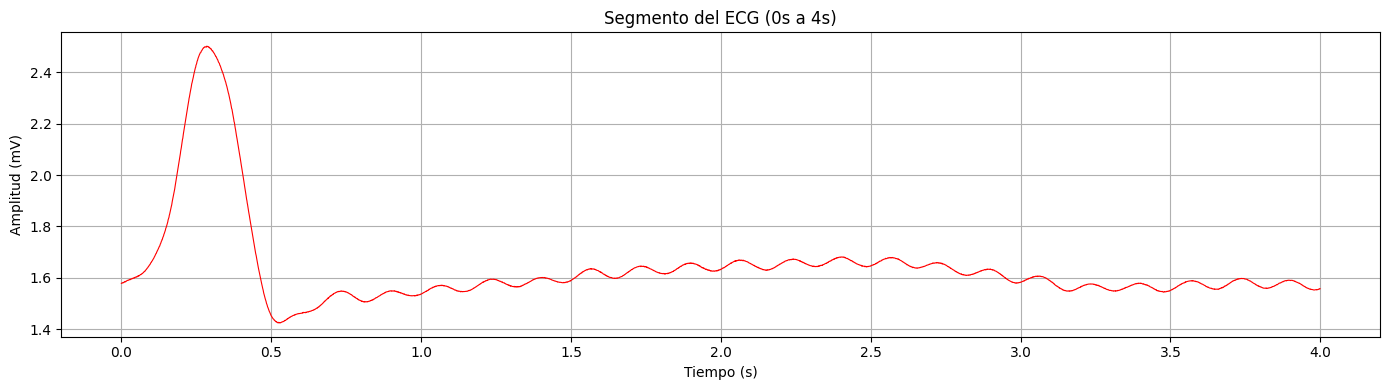

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Cargar señal ECG desde Drive
from google.colab import drive
drive.mount('/content/drive')

# Ruta del archivo
ruta = '/content/lab 5 senal.txt'

# Cargar datos
data = np.loadtxt(ruta)    # <--- ESTA LÍNEA FALTABA
ecg = data[:, 1]           # segunda columna

# Frecuencia de muestreo
fs = 1000  # Hz

# Crear vector de tiempo
t = np.arange(len(ecg)) / fs

# Graficar un segmento

inicio = 0        # en segundos
duracion = 4      # segundos
m1 = int(inicio * fs)
m2 = int((inicio + duracion) * fs)

plt.figure(figsize=(14,4))
plt.plot(t[m1:m2], ecg[m1:m2], linewidth=0.8, color="red")
plt.title(f"Segmento del ECG ({inicio}s a {inicio+duracion}s)")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud (mV)")
plt.grid(True)
plt.tight_layout()
plt.show()


## PARTE B

Forma de la señal: (2809000,)
Duración total (s): 2809.0
Coeficientes b: [ 0.00017486  0.         -0.00069943  0.          0.00104914  0.
 -0.00069943  0.          0.00017486]
Coeficientes a: [  1.          -7.34933005  23.65125216 -43.53501306  50.13593938
 -36.9920939   17.0779248   -4.51046272   0.52178339]


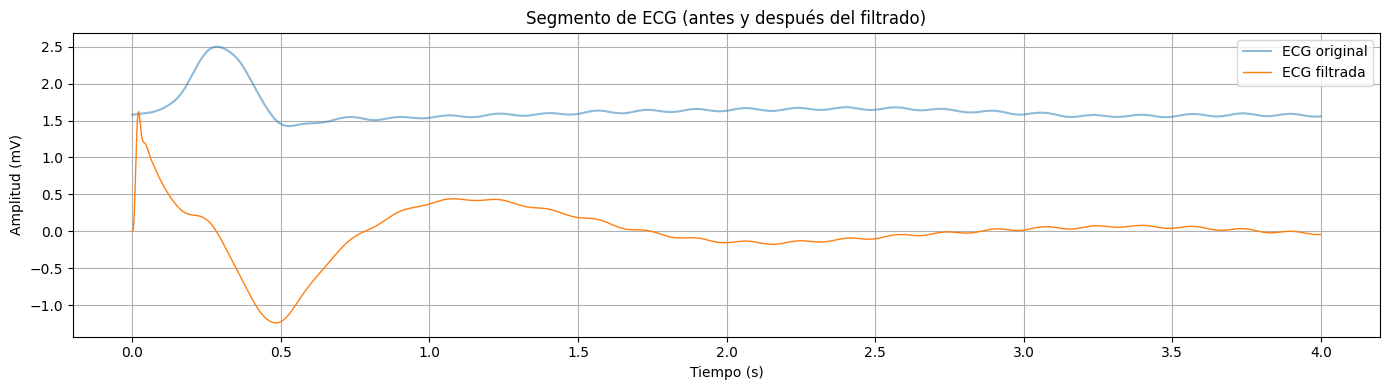

Muestras por segmento: 120000
Nº de picos R en segmento 1: 55
Nº de picos R en segmento 2: 55


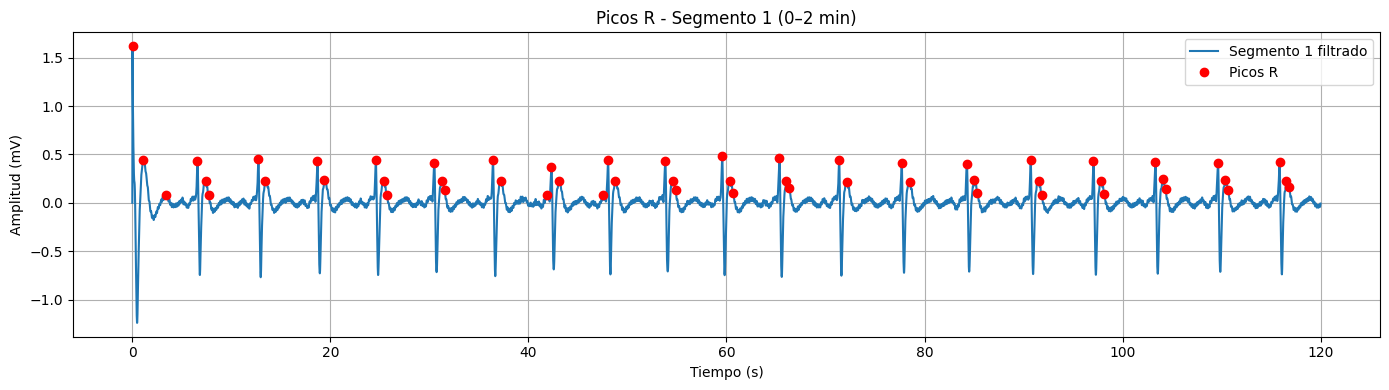

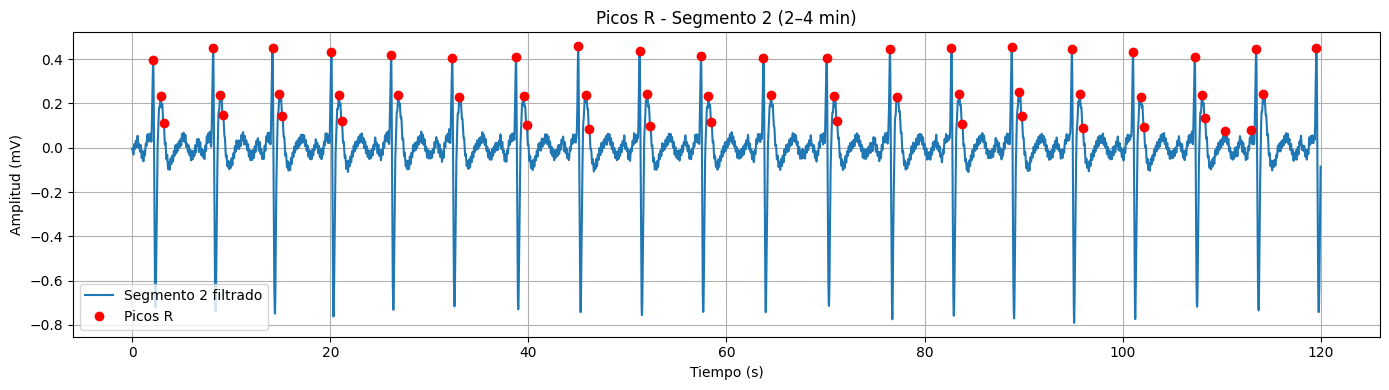

RR segmento 1 (s): [1.06  2.317 3.183 0.813 0.321 5.018 0.683 5.284 0.706 5.179]
RR segmento 2 (s): [0.76  0.314 4.991 0.704 0.305 4.985 0.703 0.303 4.931 0.761]


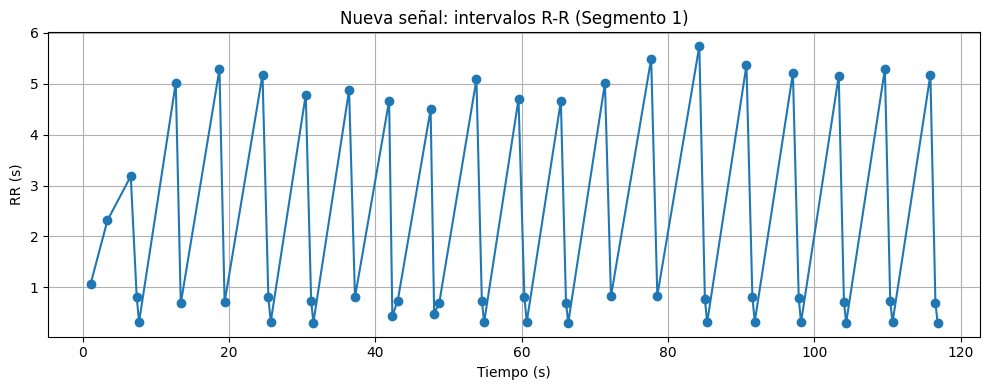

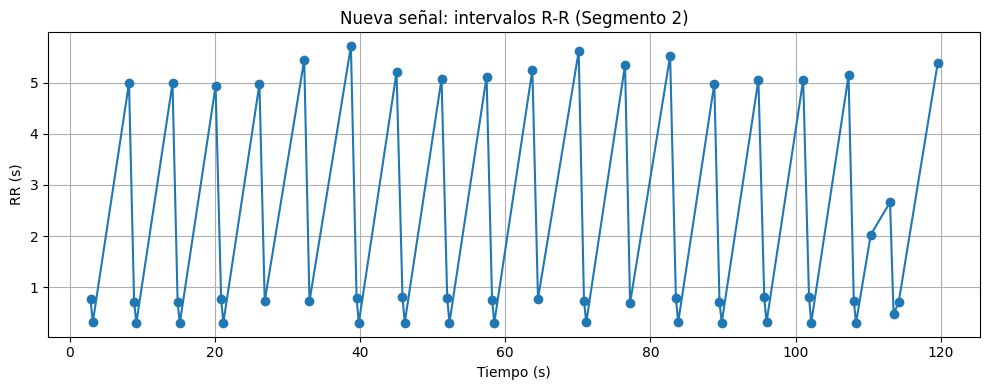

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, find_peaks

# Cargar la señal (segunda columna del .txt)

ruta = '/content/lab 5 senal.txt'

data = np.loadtxt(ruta)
ecg = data[:, 1]          # la segunda columna
fs = 1000.0               # Hz (frecuencia de muestreo)

t = np.arange(len(ecg)) / fs

print("Forma de la señal:", ecg.shape)
print("Duración total (s):", len(ecg)/fs)

# Diseño del filtro IIR (Butterworth pasa banda 0.5–40 Hz)

lowcut = 0.5   # Hz
highcut = 40.0 # Hz
order = 4      # orden del filtro IIR

nyq = fs / 2.0
low = lowcut / nyq
high = highcut / nyq

b, a = butter(order, [low, high], btype='bandpass')

print("Coeficientes b:", b)
print("Coeficientes a:", a)

# --- Ecuación en diferencias (forma general) -----------------
# y[n] = -a[1]*y[n-1] - a[2]*y[n-2] - ... - a[order]*y[n-order]
#        + b[0]*x[n] + b[1]*x[n-1] + ... + b[order]*x[n-order]
# (con condiciones iniciales y[n<0] = 0, x[n<0] = 0)

#  Implementar el filtro (condiciones iniciales en 0)

ecg_filt = lfilter(b, a, ecg)   # lfilter asume condiciones iniciales en 0

# Comparar un segmento antes / después del filtrado
inicio = 0       # s
duracion = 4     # s
m1 = int(inicio * fs)
m2 = int((inicio + duracion) * fs)

plt.figure(figsize=(14,4))
plt.plot(t[m1:m2], ecg[m1:m2], label="ECG original", alpha=0.5)
plt.plot(t[m1:m2], ecg_filt[m1:m2], label="ECG filtrada", linewidth=1)
plt.title("Segmento de ECG (antes y después del filtrado)")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud (mV)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Dividir la señal filtrada en 2 segmentos de 2 min

dur_seg = 120  # segundos (2 minutos)
N_seg = int(dur_seg * fs)

seg1 = ecg_filt[0:N_seg]
seg2 = ecg_filt[N_seg:2*N_seg]

t1 = np.arange(len(seg1)) / fs
t2 = np.arange(len(seg2)) / fs

print("Muestras por segmento:", N_seg)

# Detección de picos R en cada segmento

# Parámetros básicos para find_peaks
dist_min = int(0.3 * fs)  # al menos 300 ms entre latidos
thr1 = np.mean(seg1) + 0.5*np.std(seg1)
thr2 = np.mean(seg2) + 0.5*np.std(seg2)

peaks1, _ = find_peaks(seg1, distance=dist_min, height=thr1)
peaks2, _ = find_peaks(seg2, distance=dist_min, height=thr2)

print("Nº de picos R en segmento 1:", len(peaks1))
print("Nº de picos R en segmento 2:", len(peaks2))

# Graficar picos R en cada segmento
plt.figure(figsize=(14,4))
plt.plot(t1, seg1, label="Segmento 1 filtrado")
plt.plot(t1[peaks1], seg1[peaks1], "ro", label="Picos R")
plt.title("Picos R - Segmento 1 (0–2 min)")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud (mV)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(14,4))
plt.plot(t2, seg2, label="Segmento 2 filtrado")
plt.plot(t2[peaks2], seg2[peaks2], "ro", label="Picos R")
plt.title("Picos R - Segmento 2 (2–4 min)")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud (mV)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Intervalos R-R en segundos
rr1 = np.diff(peaks1) / fs
rr2 = np.diff(peaks2) / fs

# Tiempo asociado a cada RR (tomar el punto medio entre dos R)
t_rr1 = t1[peaks1[1:]]   # o (t1[peaks1[1:]] + t1[peaks1[:-1]])/2
t_rr2 = t2[peaks2[1:]]

print("RR segmento 1 (s):", rr1[:10])
print("RR segmento 2 (s):", rr2[:10])

# Graficar nueva señal: serie R-R
plt.figure(figsize=(10,4))
plt.plot(t_rr1, rr1, "-o")
plt.title("Nueva señal: intervalos R-R (Segmento 1)")
plt.xlabel("Tiempo (s)")
plt.ylabel("RR (s)")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,4))
plt.plot(t_rr2, rr2, "-o")
plt.title("Nueva señal: intervalos R-R (Segmento 2)")
plt.xlabel("Tiempo (s)")
plt.ylabel("RR (s)")
plt.grid(True)
plt.tight_layout()
plt.show()


# D

In [ ]:
import numpy as np
import pandas as pd

# ======================================
# rr1 y rr2 ya deben existir del paso anterior
# rr1 = intervalos RR del segmento 1 (0–2 min)
# rr2 = intervalos RR del segmento 2 (2–4 min)
# ======================================

# --- Métricas de HRV en dominio del tiempo ---

def hrv_time_domain(rr):
    mean_rr = np.mean(rr)                  # media RR
    sdnn = np.std(rr, ddof=1)              # desviación estándar RR
    rmssd = np.sqrt(np.mean(np.diff(rr)**2))  # RMSSD
    return mean_rr, sdnn, rmssd

mean1, sdnn1, rmssd1 = hrv_time_domain(rr1)
mean2, sdnn2, rmssd2 = hrv_time_domain(rr2)

# Tabla en pandas para mostrar resultados
tabla = pd.DataFrame({
    "Métrica": ["Media RR (s)", "SDNN (s)", "RMSSD (s)"],
    "Segmento 1 (0–2 min)": [mean1, sdnn1, rmssd1],
    "Segmento 2 (2–4 min)": [mean2, sdnn2, rmssd2]
})

tabla

,Métrica,Segmento 1 (0–2 min),Segmento 2 (2–4 min)
0,Media RR (s),2.163370,2.175389
1,SDNN (s),2.129005,2.202324
2,RMSSD (s),3.712926,3.787387


## PARTE C

Segmento 1 (0–2 min):
  SD1  = 2.650539693174645 s
  SD2  = 1.428271801303841 s
  CVI  = 0.5781451742947568
  CSI  = 0.5388607478626926

Segmento 2 (2–4 min):
  SD1  = 2.703001351639806 s
  SD2  = 1.5473360759793233 s
  CVI  = 0.6214309140542406
  CSI  = 0.5724510922055642


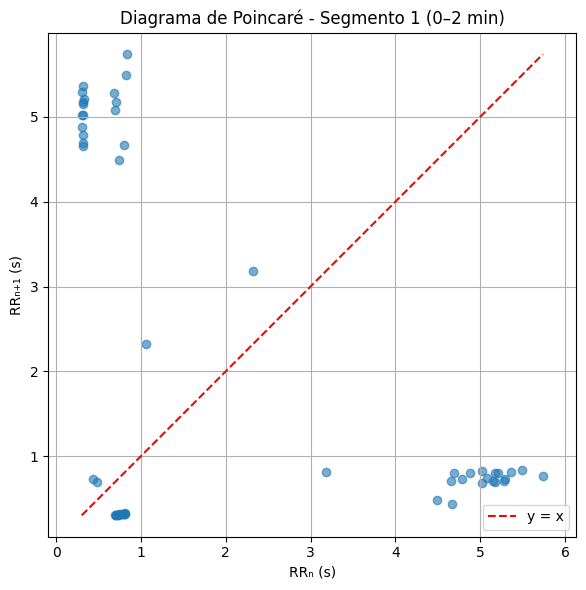

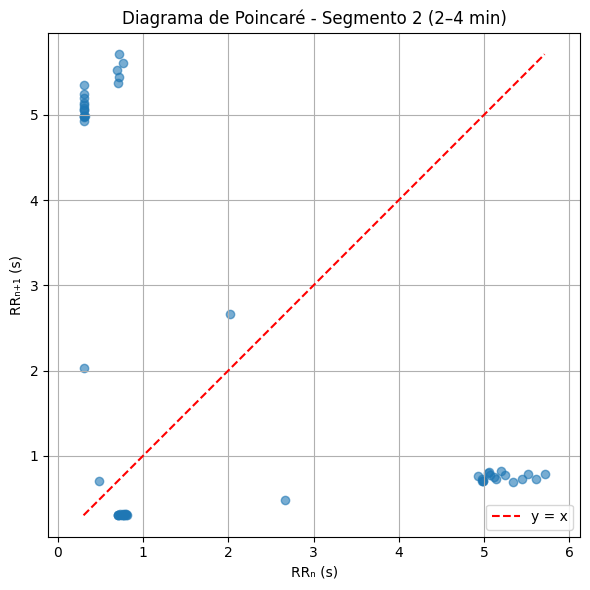

,Métrica,Segmento 1 (0–2 min),Segmento 2 (2–4 min)
0,SD1 (s),2.650540,2.703001
1,SD2 (s),1.428272,1.547336
2,CVI,0.578145,0.621431
3,CSI,0.538861,0.572451


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Función para obtener SD1, SD2, CVI y CSI
def poincare_indices(rr):
    rr = np.asarray(rr)

    # Puntos para el diagrama (RR_n, RR_{n+1})
    rr_n = rr[:-1]
    rr_n1 = rr[1:]

    # Diferencias sucesivas
    diff_rr = rr_n1 - rr_n

    # SD1 y SD2 según definiciones estándar
    sd1 = np.sqrt(0.5) * np.std(diff_rr, ddof=1)            # corto plazo (vagal)
    sd2 = np.sqrt(2 * np.std(rr, ddof=1)**2 - 0.5 * np.std(diff_rr, ddof=1)**2)  # largo plazo

    # Índices de actividad autonómica
    cvi = np.log10(sd1 * sd2)      # Cardiac Vagal Index
    csi = sd2 / sd1                # Cardiac Sympathetic Index

    return rr_n, rr_n1, sd1, sd2, cvi, csi

# Calcular índices para cada segmento
rr1_n, rr1_n1, sd1_1, sd2_1, cvi_1, csi_1 = poincare_indices(rr1)
rr2_n, rr2_n1, sd1_2, sd2_2, cvi_2, csi_2 = poincare_indices(rr2)

print("Segmento 1 (0–2 min):")
print("  SD1  =", sd1_1, "s")
print("  SD2  =", sd2_1, "s")
print("  CVI  =", cvi_1)
print("  CSI  =", csi_1)

print("\nSegmento 2 (2–4 min):")
print("  SD1  =", sd1_2, "s")
print("  SD2  =", sd2_2, "s")
print("  CVI  =", cvi_2)
print("  CSI  =", csi_2)

# Diagramas de Poincaré para cada segmento
plt.figure(figsize=(6,6))
plt.scatter(rr1_n, rr1_n1, alpha=0.6)
plt.plot([min(rr1), max(rr1)], [min(rr1), max(rr1)], 'r--', label='y = x')
plt.xlabel("RRₙ (s)")
plt.ylabel("RRₙ₊₁ (s)")
plt.title("Diagrama de Poincaré - Segmento 1 (0–2 min)")
plt.grid(True)
plt.axis('equal')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,6))
plt.scatter(rr2_n, rr2_n1, alpha=0.6)
plt.plot([min(rr2), max(rr2)], [min(rr2), max(rr2)], 'r--', label='y = x')
plt.xlabel("RRₙ (s)")
plt.ylabel("RRₙ₊₁ (s)")
plt.title("Diagrama de Poincaré - Segmento 2 (2–4 min)")
plt.grid(True)
plt.axis('equal')
plt.legend()
plt.tight_layout()
plt.show()

# Tabla comparativa

tabla_poincare = pd.DataFrame({
    "Métrica": ["SD1 (s)", "SD2 (s)", "CVI", "CSI"],
    "Segmento 1 (0–2 min)": [sd1_1, sd2_1, cvi_1, csi_1],
    "Segmento 2 (2–4 min)": [sd1_2, sd2_2, cvi_2, csi_2]
})

tabla_poincare
